In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.colors as colors # Coloring
import seaborn as sns

In [2]:
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

def volcano_data(data, groupA, groupB):
    A = data[groupA]
    B = data[groupB]
    genes = data.index
    volcano = np.zeros((len(genes),2))

    for i,gene in enumerate(genes):
        A_gene = np.array(A.loc[gene])
        B_gene = np.array(B.loc[gene])
        volcano[i,0] = (stats.ttest_ind(A_gene,B_gene)[1])
        volcano[i,1] = np.log2(A_gene.mean()/B_gene.mean())
    qval = fdr(volcano[:,0])
    volcano[:,0] = -np.log10(qval)
    volcano = pd.DataFrame(volcano, columns=['-Log10 q-value','Log2 fold change'], index=genes)
    return volcano

def volcano_plot(data, fc_threshold, p_threshold,name=None):
    data.columns = ['y','x']
    data['group'] = 'black'
    data.loc[(data.x > fc_threshold)&(data.y > p_threshold),'group'] = 'tab:red'
    data.loc[(data.x < -fc_threshold)&(data.y > p_threshold),'group'] = 'tab:blue'
    data.loc[data.y < p_threshold,'group'] = 'dimgrey' #阈值以下点为灰色
    xmin = -8
    xmax = 8
    ymin = 0
    ymax = 8
    #绘制散点图
    fig = plt.figure(figsize=(3,4)) 
    ax = fig.add_subplot()
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['x'], data['y'], s=2, c=data['group'])
    ax.scatter(data.loc['RAB11FIP5']['x'], data.loc['RAB11FIP5']['y'], c='orange', marker='*')
#     ax.scatter(data.loc['NOP2']['x'], data.loc['NOP2']['y'], c='grey', marker='D')
    ax.spines['right'].set_visible(False) #去掉右边框
    ax.spines['top'].set_visible(False) #去掉上边框

    #水平和竖直线
    ax.vlines(-fc_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    ax.vlines(fc_threshold, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖直线
    ax.hlines(p_threshold, xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1) #画竖水平线

    ax.set_xticks(range(xmin,xmax,2)) #设置x轴刻度起点和步长
    ax.set_yticks(range(ymin,ymax,1)) #设置y轴刻度起点和步长
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 q-value')
    plt.tight_layout()
    if name is not None:
        plt.savefig(name+'_vocano.eps', format='eps', dpi=300)
    plt.show()

In [3]:
metadata = pd.read_csv('pbmc_meta.csv',index_col=0)
metadata = metadata.loc[metadata['virus']=='HIV']
BNab = metadata.loc[metadata['Condition']=='BNab'].index
Cont = metadata.loc[metadata['Condition']=='control'].index

In [4]:
HIV_deseq = pd.read_csv('HIV_deseq2.csv',index_col=0)

In [5]:
HIV_deseq['-Log10 q-value'] = -np.log10(HIV_deseq['padj'])
HIV_deseq['Log2 fold change'] = HIV_deseq['log2FoldChange']
HIV_deseq.drop(['baseMean','log2FoldChange','lfcSE','stat','pvalue','padj'],axis=1,inplace=True)

In [6]:
csx_NK = pd.read_csv("~/Desktop/Chan's Research/2021Summer Intern/MajorReview/CSx/HIV_highresolutionGEP_result/CIBERSORTxHiRes_Job13_NK_Window24.txt",sep='\t',index_col=0)

In [7]:
NK = pd.read_csv('HIV_NK_sigm.txt',sep='\t',index_col=0)
Monocytes = pd.read_csv('HIV_Monocytes_sigm.txt',sep='\t',index_col=0)
CD4T = pd.read_csv('HIV_CD4Tcells_sigm.txt',sep='\t',index_col=0)
CD8T = pd.read_csv('HIV_CD8Tcells_sigm.txt',sep='\t',index_col=0)
Bcell = pd.read_csv('HIV_Bcells_sigm.txt',sep='\t',index_col=0)
Den = pd.read_csv('HIV_Dendritics_sigm.txt',sep='\t',index_col=0)
HIV = pd.read_csv('HIV_pbmc.csv',sep=',',index_col=0).T
samplename = HIV.columns
genename = HIV.index

In [8]:
DEGs_bulk = HIV_deseq.loc[HIV_deseq['-Log10 q-value'] > 2,:].index

In [9]:
def detection(volcano, DEGs=DEGs_bulk):
    genes = volcano.index.intersection(DEGs)
    overlapping = []
    for name in genes:
        if volcano.loc[name]['-Log10 q-value'] > 1.3010:
            overlapping.append(name)
            print(name)
    print(len(overlapping))

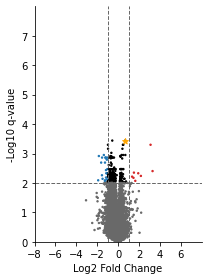

In [10]:
volcano_plot(HIV_deseq, 1, 2, name='HIV_deseq')

NK_Subsets


/Users/chan/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/chan/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/chan/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


RAB11FIP5
NOP2
2


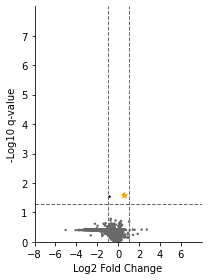

Bcell_Subsets
0


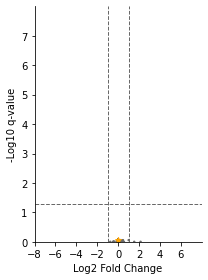

Dendritics_Subsets
0


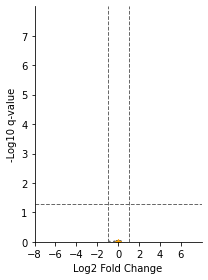

CD4Tcell_Subsets
0


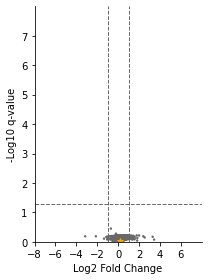

CD8Tcell_Subsets
0


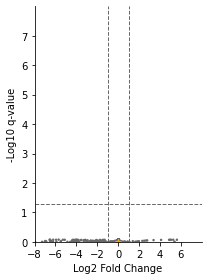

Mono_Subsets
0


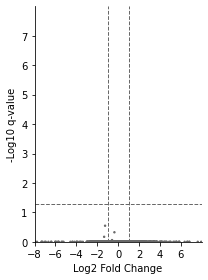

In [11]:
print('NK_Subsets')
NK_volcano = volcano_data(NK, BNab, Cont)
detection(NK_volcano)
volcano_plot(NK_volcano, 1, 1.3010, 'TAPE_NK')

print('Bcell_Subsets')
Bcell_volcano = volcano_data(Bcell, BNab, Cont)
detection(Bcell_volcano)
volcano_plot(Bcell_volcano, 1, 1.3010, 'TAPE_Bcell')

print('Dendritics_Subsets')
Den_volcano = volcano_data(Den, BNab, Cont)
detection(Den_volcano)
volcano_plot(Den_volcano, 1, 1.3010, 'TAPE_Dendritics')

print('CD4Tcell_Subsets')
CD4T_volcano = volcano_data(CD4T, BNab, Cont)
detection(CD4T_volcano)
volcano_plot(CD4T_volcano, 1, 1.3010, 'TAPE_CD4Tcell')

print('CD8Tcell_Subsets')
CD8T_volcano = volcano_data(CD8T, BNab, Cont)
detection(CD8T_volcano)
volcano_plot(CD8T_volcano, 1, 1.3010, 'TAPE_CD8Tcell')

print('Mono_Subsets')
Mon_volcano = volcano_data(Monocytes, BNab, Cont)
detection(Mon_volcano)
volcano_plot(Mon_volcano, 1, 1.3010, 'TAPE_Monocyte')


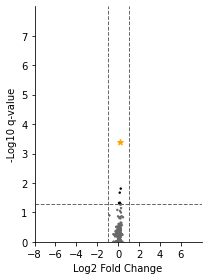

In [12]:
csx_volcano = volcano_data(csx_NK, BNab, Cont)
volcano_plot(csx_volcano, 1, 1.3010,'CSx_NK')

In [13]:
df = pd.concat((Bcell.loc['RAB11FIP5'],CD4T.loc['RAB11FIP5'],
                CD8T.loc['RAB11FIP5'],Den.loc['RAB11FIP5'],
                Monocytes.loc['RAB11FIP5'],NK.loc['RAB11FIP5']))
df = pd.DataFrame(df.values, columns=['Expression Value'],index=df.index)

In [14]:
Type = []
for x in df.index:
    if x in BNab:
        Type.append('BNab')
    elif x in Cont:
        Type.append('control')
Cell = ['Bcell' for i in range(92)]+ \
       ['CD4Tcell' for i in range(92)]+ \
       ['CD8Tcell' for i in range(92)]+ \
       ['Dendritics' for i in range(92)]+ \
       ['Monocyte' for i in range(92)]+ \
       ['NK' for i in range(92)]

In [15]:
df['Type'] = Type
df['Cell Type'] = Cell

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


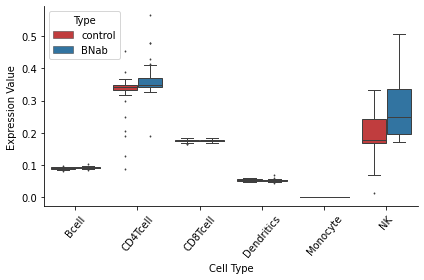

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x="Cell Type", y="Expression Value", hue="Type",hue_order=['control','BNab'],
            data=df, palette={'control':sns.color_palette()[3],'BNab':sns.color_palette()[0]}, ax=ax,
            fliersize=1,linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=50)
plt.tight_layout()
fig.savefig('rab11fip5_hiv_tape.eps', format='eps', dpi=300)

plt.show()

In [17]:
csx = csx_NK.loc['RAB11FIP5']
Type = []
for x in csx.index:
    if x in BNab:
        Type.append('BNab')
    elif x in Cont:
        Type.append('control')

In [18]:
csx = pd.DataFrame(csx)
csx['Type'] = Type
csx['CellType'] = 'NK'

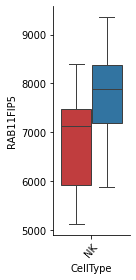

In [19]:
fig, ax = plt.subplots(figsize=(2,4))
sns.boxplot(x='CellType',y="RAB11FIP5", hue="Type",hue_order=['control','BNab'],
            data=csx, palette={'control':sns.color_palette()[3],'BNab':sns.color_palette()[0]}, ax=ax,
            fliersize=1,linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=50)
ax.get_legend().remove()
plt.tight_layout()

fig.savefig('rab11fip5_hiv_csx.eps', format='eps', dpi=300)
plt.show()